In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

from ClusterPipeline import ClusterPipeline
from helper import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import umap

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
def get_split_index(features, labels, test_size=0.1):
    import numpy as np
    from sklearn.model_selection import StratifiedShuffleSplit
    
    features = np.array(features)
    # The train set will have equal amounts of each target class
    # Performing single split
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    return [[train_index, test_index] for train_index,test_index in split.split(features, labels)]

def split_valid(features, training_labels, valid_size=0.5):
    train_index, validation_index = get_split_index(features, training_labels, test_size=valid_size)[0]
    
    X_valid, y_valid = features.iloc[validation_index], training_labels.iloc[validation_index]
    X_train, y_train = features.iloc[train_index], training_labels.iloc[train_index]
     
    return X_train, y_train, X_valid, y_valid

In [ ]:
# raw_data = pd.read_csv("data/heart.csv")
# original_data = raw_data.drop(columns=["target"])
# training_labels = raw_data["target"]
# raw_data.head()

raw_data = pd.read_csv("data/original_heart.csv").astype(np.float64)
raw_data.hist(bins=25, figsize=(20,15))

In [5]:
# Categorical Types:
# Binary: sex, exang, fbs
# Multiclass: cp, restecg, thal

original_data = raw_data.drop(columns=["oldpeak", "target"]).astype(np.int64)
original_data["oldpeak"] = raw_data["oldpeak"] # To keep it as a float
original_data = pd.get_dummies(original_data, 
                               columns=["cp","restecg","thal"],
                               prefix=["cp","restecg","thal"])
original_labels = raw_data["target"].astype(np.int64)

training_labels = raw_data["target"].astype(np.int64)
training_labels[training_labels > 0] = 1

print("Original Distribution:\n",original_labels.value_counts(), sep="")
print("Combined:\n",training_labels.value_counts(), sep="")

original_data.head()

Original Distribution:
0    160
1     54
3     35
2     35
4     13
Name: target, dtype: int64
Combined:
0    160
1    137
Name: target, dtype: int64


,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
0,63,1,145,233,1,150,0,3,0,2.3,1,0,0,0,0,0,1,0,1,0
1,67,1,160,286,0,108,1,2,3,1.5,0,0,0,1,0,0,1,1,0,0
2,67,1,120,229,0,129,1,2,2,2.6,0,0,0,1,0,0,1,0,0,1
3,37,1,130,250,0,187,0,3,0,3.5,0,0,1,0,1,0,0,1,0,0
4,41,0,130,204,0,172,0,1,0,1.4,0,1,0,0,0,0,1,1,0,0


In [6]:
original_data.shape

(297, 20)

In [7]:
def exp_decay(epoch):
    initial_lr = 0.1
    decay_steps = 50
    decay_rate = 0.1
    
    decayed_lr =  initial_lr * np.power(decay_rate, (epoch/decay_steps))
#     print("New Learning Rate:", decayed_lr)
    return decayed_lr

def build_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

#     dnn.add(Dense(units = 50, activation="elu", input_dim=num_features,
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 25, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units = 25, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 25, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units=10, activation='elu',
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

In [8]:
## Need to define a scaling function that ignores categorical values...?

In [9]:
nn = build_dnn(num_features=original_data.shape[1])
nn.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                525       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 52        
Total params: 1,227
Trainable params: 1,227
Non-trainable params: 0
___________________

Using TensorFlow backend.


In [10]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=15,
                    min_dist=0)

# Separating a hold out set that will be used for validation later
X_train, y_train, X_valid, y_valid = split_valid(original_data, training_labels, valid_size=0.1)    

pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid,y_valid], target_class=1, reducer=reducer)

pipeline.train_model(batch_size=20,epochs=100, cross_validation=True, parallel=False, verbose=0)

Running Serial Crossvalidation
Running worker: 0
Instructions for updating:
Use tf.cast instead.
Fold: 0 -> Loss:0.460, Acc:0.8876
Prediction Accuracy
28/28 [==============================] - 0s 1ms/step
Scores on data set: loss=0.570 accuracy=0.8214
Fold Correct: 23
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Running worker: 1
Fold: 1 -> Loss:0.499, Acc:0.8605
Prediction Accuracy
28/28 [==============================] - 0s 19us/step
Scores on data set: loss=0.459 accuracy=0.8214
Fold Correct: 23
Running worker: 2
Fold: 2 -> Loss:0.460, Acc:0.8760
Prediction Accuracy
28/28 [==============================] - 0s 19us/step
Scores on data set: loss=0.695 accuracy=0.8214
Fold Correct: 23
Running worker: 3
Fold: 3 -> Loss:0.484, Acc:0.8798
Prediction Accuracy
27/27 [==============================] - 0s 26us/step
Scores on data set: loss=0.595 accuracy=0.8148
Fold Correct: 22
Running worker: 4
Fold: 4 -> Loss:0.435, Acc:0.8885
Prediction Accuracy
26/26 [=====

Confusion matrix, without normalization
[[0.86805556 0.13194444]
 [0.20325203 0.79674797]]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2d3a7f60>, array([[125,  19],
        [ 25,  98]]))

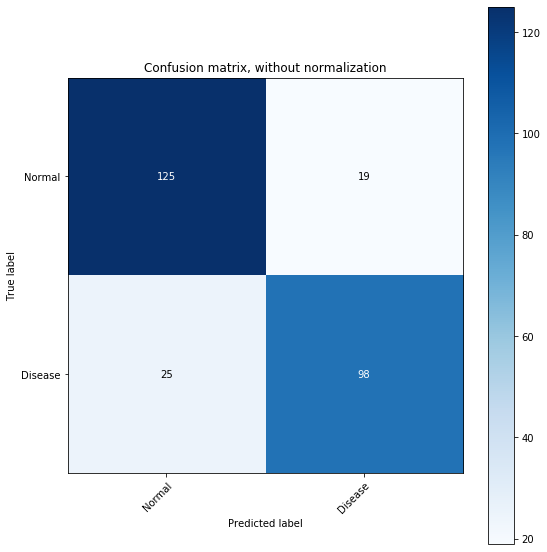

In [11]:
plot_confusion_matrix(y_train.values[pipeline.testing_idxs], np.array(pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

In [12]:
# min_cluster_sizes=range(3,20,1)
pipeline.train_clusterer(class_label=1, plot=False)

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning:

Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../anaconda3/envs/condatensor/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^


/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/numba/compiler.py:751

Minimum Size:
Clusters                  (12, 12)
Noise                     (12, 12)
Halkidi                   (12, 12)
Halkidi-Filtered Noise    (12, 12)
dtype: object


,Clusters,Noise,Halkidi,Halkidi-Filtered Noise
"(12, 12)",2,0.0,0.334893,0.334893
"(13, 12)",2,0.0,0.334893,0.334893
"(13, 13)",2,0.0,0.334893,0.334893
"(14, 12)",2,0.0,0.334893,0.334893
"(14, 13)",2,0.0,0.334893,0.334893
"(14, 14)",2,0.0,0.334893,0.334893
"(15, 12)",2,0.0,0.334893,0.334893
"(15, 13)",2,0.0,0.334893,0.334893
"(15, 14)",2,0.0,0.334893,0.334893
"(15, 15)",2,0.0,0.334893,0.334893


In [13]:
pipeline.training_lrp.shape

(98, 20)

In [14]:
pd.Series(pipeline.clusterer.labels_).value_counts()

0    58
1    40
dtype: int64

In [15]:
# Internally populates self.val_set_lrp
samples, cluster_labels = pipeline.get_validation_clusters()

Loading LRP Analyzers...
Done!
Prediction Accuracy: 0.8000


In [16]:
pd.Series(cluster_labels).value_counts()

0    8
1    2
dtype: int64

In [17]:
pipeline.target_class

1

## Plotting Relevance Clusters

In [18]:
training_lrp = pipeline.training_lrp
val_lrp = pipeline.val_set_lrp
training_lrp.shape

(98, 20)

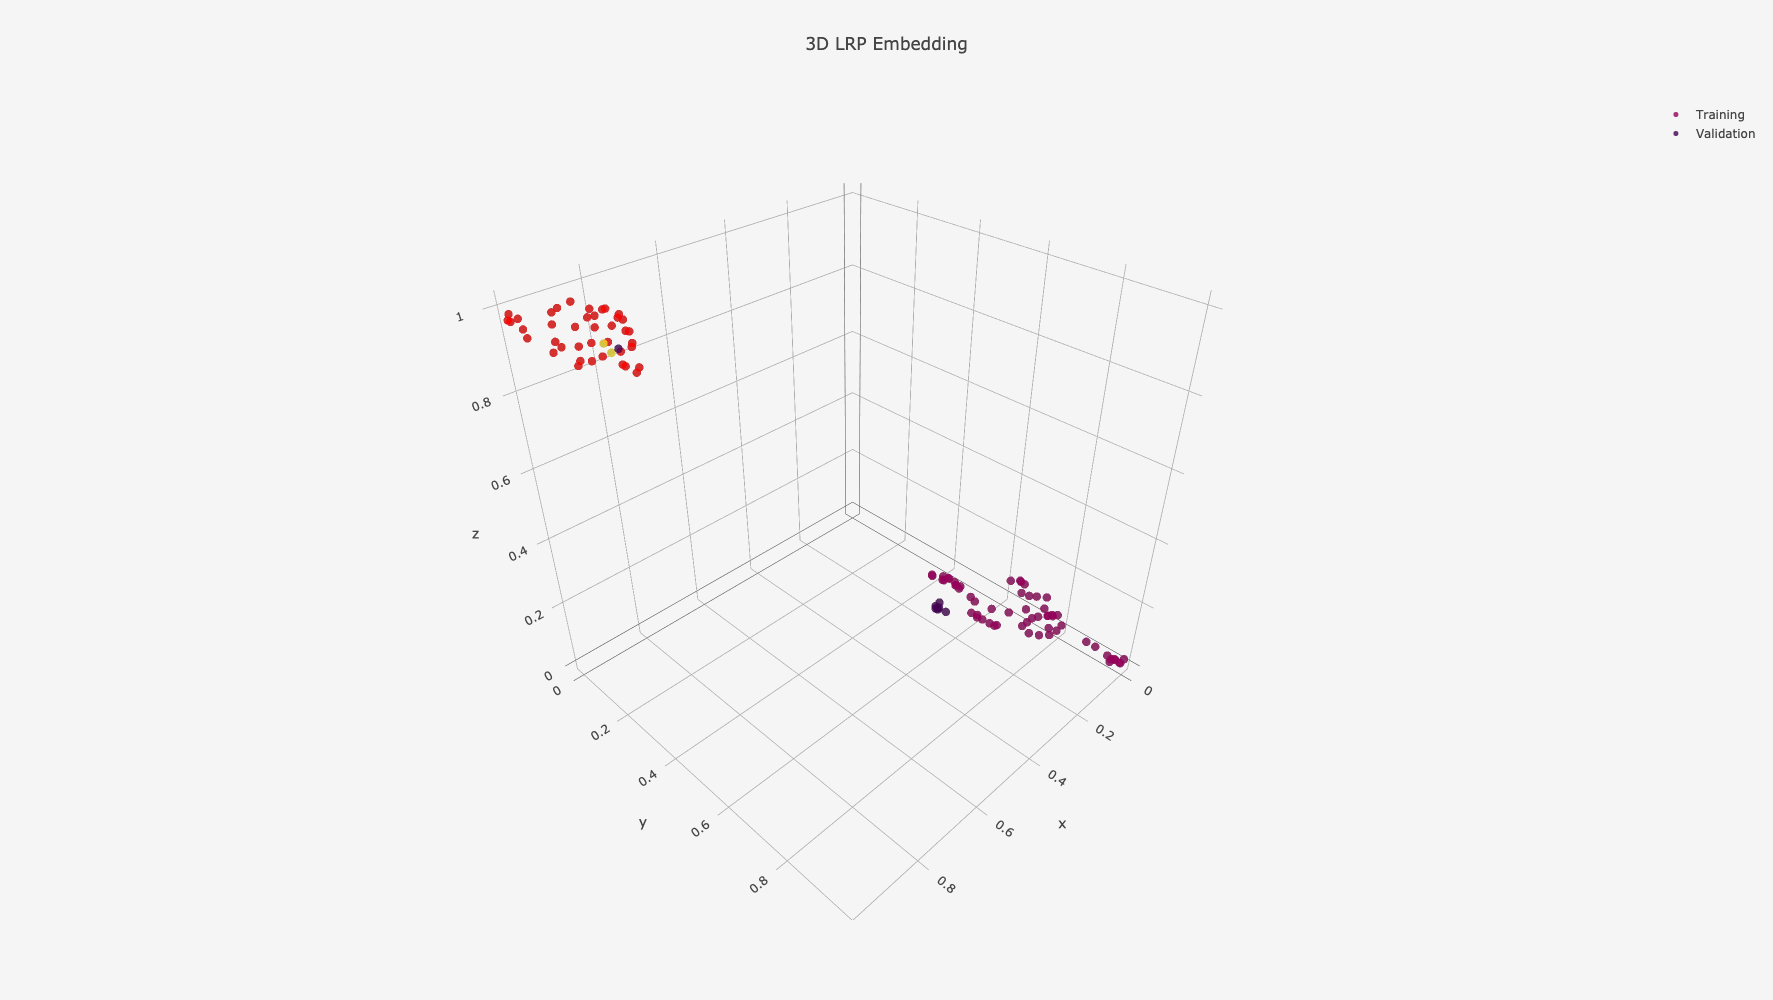

In [19]:
# pipeline.reducer_pipeline[0].n_neighbors
embedding_pipeline = Pipeline([
    ("reducer", umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=10,
                    min_dist=0)),
   ("scaler", MinMaxScaler())
])
embedding_pipeline.fit(training_lrp)

embedding = embedding_pipeline.transform(training_lrp)

emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=5,
        color=pipeline.clusterer.labels_,
        colorscale="Rainbow",
        opacity=0.8
    ),
    text=pipeline.clusterer.labels_
)

val_3d_embedding = embedding_pipeline.transform(val_lrp)

val_emb3d = go.Scatter3d(
    x=val_3d_embedding[:,0],
    y=val_3d_embedding[:,1],
    z=val_3d_embedding[:,2],
    name="Validation",
    mode="markers",
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
#         showscale=True
    ),
    text = cluster_labels
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5',
#     template="plotly"
)


data=[emb3d, val_emb3d]

fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template="plotly")  /

iplot(fig, filename='lrp-3d-scatter.html')

# Performing Feature Reduction

In [20]:
def get_relevant_cols(df, thresh = 1e-2):

    all_above_thresh = (df < thresh).all(0) #Check if all values in columns satisfy the criteria
    max_above_thresh = (df.max() < thresh)
    quantile_above_thresh = (df.quantile(0.8) <= thresh)

    criteria = quantile_above_thresh
    irrelevant_cols = df.columns[criteria] 
    irrelevant_cols
    
    relevant_features_only = df.drop(columns = irrelevant_cols)
    
    return relevant_features_only

## Getting largest subcluster samples from validation set

In [21]:
max(pipeline.clusterer.labels_)
[x for x in range(0,0)]

[]

In [22]:
subcluster_labels = range(0,max(pipeline.clusterer.labels_)+1)

# Get testing samples from cross validation
reindexer = pipeline.testing_idxs

# That were correctly predicted
correct_preds = pipeline.correct_preds_bool_arr

# Separating Control from Target
target_samples  = y_train.iloc[reindexer][correct_preds] == pipeline.target_class
control_samples = ~target_samples

target_class_features = X_train.iloc[reindexer][correct_preds][target_samples]
target_class_labels   = y_train.iloc[reindexer][correct_preds][target_samples]
target_class_features.head()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
122,55,1,140,217,0,111,1,3,0,5.6,0,0,0,1,1,0,0,0,0,1
24,60,1,130,206,0,132,1,2,2,2.4,0,0,0,1,0,0,1,0,0,1
137,35,1,120,198,0,130,1,2,0,1.6,0,0,0,1,1,0,0,0,0,1
79,58,1,150,270,0,111,1,1,0,0.8,0,0,0,1,0,0,1,0,0,1
120,63,0,150,407,0,154,0,2,3,4.0,0,0,0,1,0,0,1,0,0,1


In [23]:
# target_class_features[(pipeline.clusterer.labels_ == cluster_label)]

In [24]:
training_lrp.shape

(98, 20)

## Using reduced features for retraining

> **Only values from the same cluster can be retrained**

In [48]:
cluster_train = {}

for cluster_label in subcluster_labels:
    
    tsamples = target_class_features[(pipeline.clusterer.labels_ == cluster_label)]
    tlabels  = target_class_labels[(pipeline.clusterer.labels_ == cluster_label)]


#     csamples = X_train.iloc[reindexer][correct_preds][control_samples]
    csamples = X_train[y_train != pipeline.target_class]
    csamples = csamples[:len(tsamples)]

    clabels = y_train.iloc[reindexer][correct_preds][control_samples]
    clabels = clabels[:len(tsamples)]
  
    _clustered = pd.DataFrame(training_lrp[(pipeline.clusterer.labels_ == cluster_label)],
                              columns = X_train.columns)
    
#     thresh = min(val_clustered.describe().loc["75%"])
    thresh = _clustered.max().min()
    print(thresh)
    reduced_cols = get_relevant_cols(_clustered, thresh=thresh).columns
    print(reduced_cols, len(reduced_cols))
    
    tsamples = tsamples[reduced_cols]
    csamples  = csamples[reduced_cols]
    
    # Now stack it with control values of same size...
    X_train_sc = pd.concat([csamples, tsamples], axis="index")
    y_train_sc = pd.concat([clabels, tlabels], axis="index")
    
    cluster_train[cluster_label] = (X_train_sc, y_train_sc)


0.052021414
Index(['sex', 'trestbps', 'chol', 'exang', 'slope', 'ca', 'oldpeak', 'cp_1',
       'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3', 'thal_7'],
      dtype='object') 14
0.015780602
Index(['sex', 'trestbps', 'chol', 'fbs', 'exang', 'slope', 'ca', 'oldpeak',
       'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3', 'thal_7'],
      dtype='object') 15


In [49]:
_clustered.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,slope,ca,oldpeak,cp_1,cp_2,cp_3,cp_4,restecg_0,restecg_1,restecg_2,thal_3,thal_6,thal_7
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,0.007108,0.108227,0.107708,0.051348,0.023564,0.016015,0.131138,0.197434,0.986407,0.302682,0.045022,0.000845,0.110050,0.361772,0.055339,0.008185,0.094735,0.104285,0.005428,0.304860
std,0.016738,0.076602,0.160500,0.066569,0.028375,0.065561,0.142148,0.170822,0.229646,0.305326,0.014027,0.003044,0.046095,0.102967,0.045161,0.051769,0.070082,0.075649,0.007626,0.218085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.645193,0.000000,0.019081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152751,0.807566,0.000000,0.033227,0.000000,0.086373,0.338700,0.000000,0.000000,0.000000,0.055464,0.000000,0.000000
50%,0.000000,0.119804,0.037737,0.024282,0.007001,0.000000,0.114132,0.190220,0.901671,0.238950,0.044575,0.000000,0.101518,0.372793,0.051746,0.000000,0.115877,0.091654,0.000843,0.374313
75%,0.001185,0.160040,0.154571,0.082465,0.045783,0.004026,0.232586,0.217519,1.173582,0.457915,0.053597,0.000000,0.133308,0.411214,0.088068,0.000000,0.136272,0.143924,0.009322,0.431020
max,0.074182,0.272960,0.582021,0.316962,0.091057,0.413968,0.500071,0.768357,1.674007,1.188521,0.086552,0.015781,0.209415,0.567302,0.161011,0.327415,0.260156,0.266199,0.025809,0.683620


In [27]:
srtd_metrics = _clustered.describe().loc[["mean","75%","max"]].sort_values(by=["mean", "75%", "max"], axis=1)

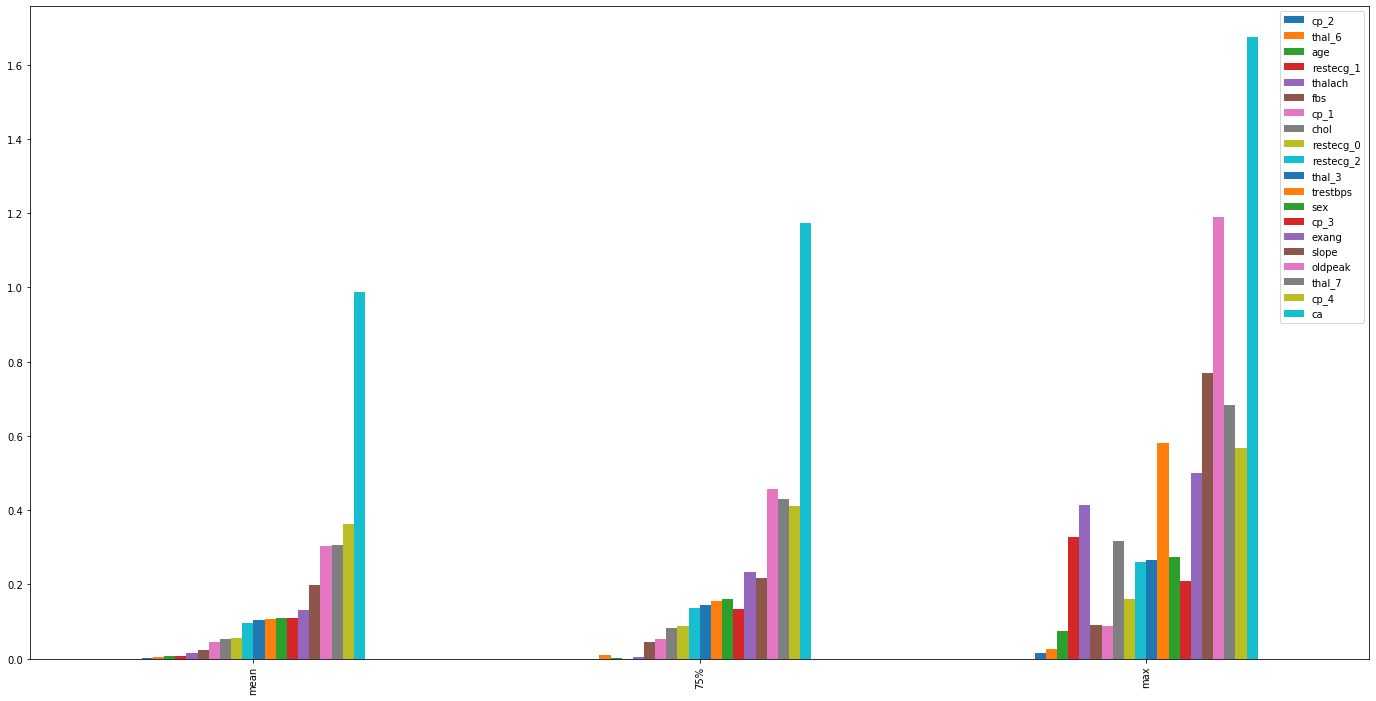

In [28]:
srtd_metrics.plot(kind="bar", figsize=(24,12))

### Baseline CN vs Subcluster

> **Reusing the same network architecture may not be valid as the samples are already biased towards it**

In [29]:
def runSubclusterAnalysis(cluster_train, dnn_build_fn, batch_size=20, epochs=100):
    results = {}
    
    for sc in cluster_train:
        X_train_sc, y_train_sc = cluster_train[sc]

        # All the samples from X_valid are used for now...
        X_valid_red = X_valid[X_train_sc.columns]

        nn = dnn_build_fn(num_features=X_train_sc.shape[1])

        _pipeline = ClusterPipeline(nn, [X_train_sc, y_train_sc], [X_valid_red, y_valid], target_class=1)
        _pipeline.train_model(batch_size=batch_size,epochs=epochs, cross_validation=True, parallel=False, verbose=0)

        _, cm = plot_confusion_matrix(y_train_sc.values[_pipeline.testing_idxs],
                              np.array(_pipeline.predictions, dtype=int),
                              np.array(["Normal", "Disease"]))
        results[sc] = cm
    return results

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.344, Acc:0.9712
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.230 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.301, Acc:0.9808
Prediction Accuracy
12/12 [==============================] - 0s 28us/step
Scores on data set: loss=0.714 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.343, Acc:0.9423
Prediction Accuracy
12/12 [==============================] - 0s 49us/step
Scores on data set: loss=0.705 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.292, Acc:0.9712
Prediction Accuracy
12/12 [==============================] - 0s 61us/step
Scores on data set: loss=0.630 accuracy=0.8333
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.242, Acc:1.0000
Prediction Accuracy
12/12 [==============================] - 0s 48us/step
Scores on data set: loss=2.203 accuracy=0.7500
Fold Correct: 9
Running worker: 5
Fol

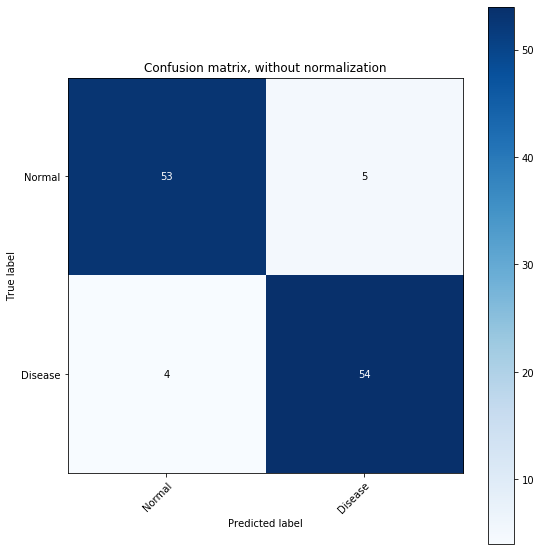

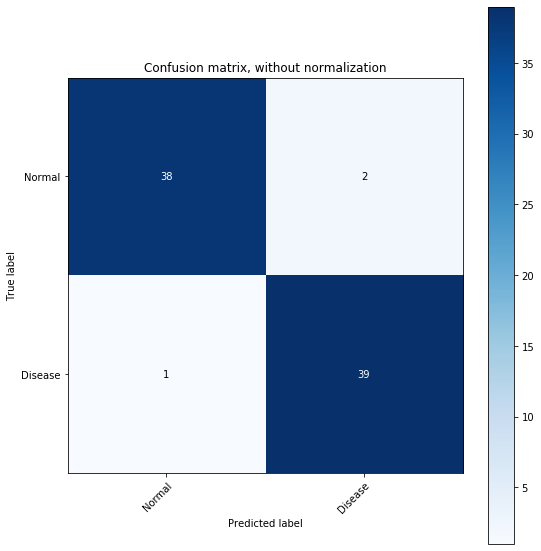

In [30]:
non_red_cluster_train = pipeline.getSubclusters(reduce=False)

%time baseline_results = runSubclusterAnalysis(non_red_cluster_train, build_dnn)

# Feeding models (feature) reduced data

In [31]:
cluster_train = pipeline.getSubclusters(reduce=True)
print(cluster_train[0][0].columns)
print(cluster_train[1][0].columns)

Index(['sex', 'trestbps', 'chol', 'exang', 'slope', 'ca', 'oldpeak', 'cp_1',
       'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3', 'thal_7'],
      dtype='object')
Index(['sex', 'trestbps', 'chol', 'fbs', 'exang', 'slope', 'ca', 'oldpeak',
       'cp_1', 'cp_3', 'cp_4', 'restecg_0', 'restecg_2', 'thal_3', 'thal_7'],
      dtype='object')


## Original architecture

### Accuracy is same as w/ original feature set
> **This is a sign that the features dropped were in fact not very useful for classifying *this* subcluster**

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.326, Acc:0.9519
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.221 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.282, Acc:0.9615
Prediction Accuracy
12/12 [==============================] - 0s 35us/step
Scores on data set: loss=0.750 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.290, Acc:0.9712
Prediction Accuracy
12/12 [==============================] - 0s 43us/step
Scores on data set: loss=0.589 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.308, Acc:0.9615
Prediction Accuracy
12/12 [==============================] - 0s 52us/step
Scores on data set: loss=0.558 accuracy=0.8333
Fold Correct: 10
Running worker: 4
Fold: 4 -> Loss:0.254, Acc:0.9712
Prediction Accuracy
12/12 [==============================] - 0s 48us/step
Scores on data set: loss=1.587 accuracy=0.7500
Fold Correct: 9
Running worker: 5
Fol

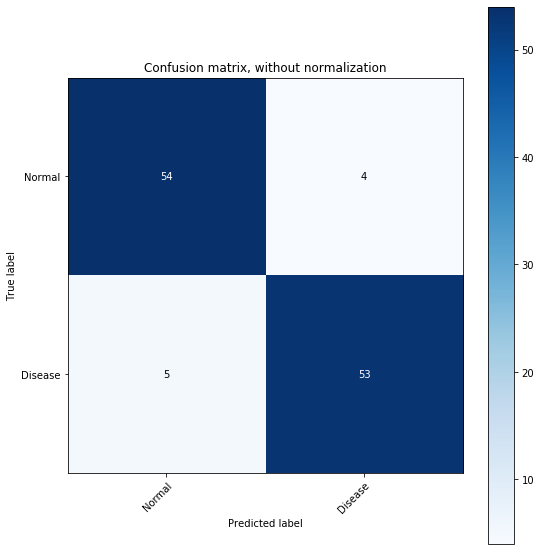

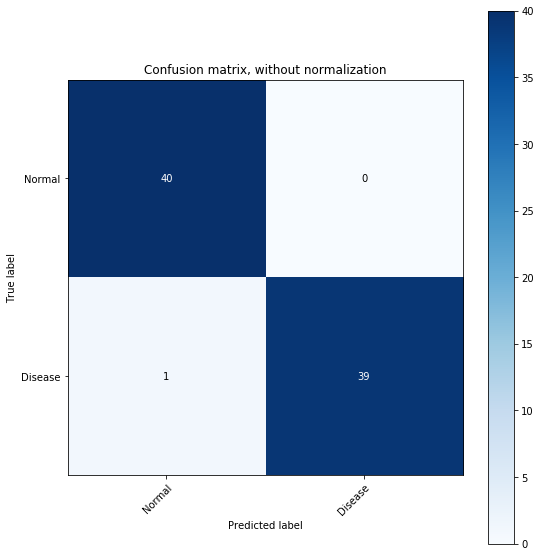

In [32]:
%time baseline_reduced_results = runSubclusterAnalysis(cluster_train, build_dnn)

# Shallow Network

## Rebuilding a (simpler) DNN architecture

In [33]:
def build_shallow_dnn(num_features, num_nodes = 16, depth = 2, num_labels=2, activation = "elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal()
    

    dnn.add(Dense(units = 15, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
#     dnn.add(Dense(units = 10, activation="elu",
#                   kernel_initializer=he_init, kernel_regularizer = my_reg))
#     dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=5, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    
    dnn.add(Dense(units=num_labels, activation="softmax",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True)
    
    dnn.compile(loss='categorical_crossentropy',
                  optimizer=NSGD,
                  metrics=['accuracy'])
    
    return dnn

### Accuracy is same as w/ original architecture

- **Using a different network architecture removes any potential sources of bias of reusing the same samples for the same network**
- **Using a shallower n/w shows us that a "simpler" classifier can work**

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.313, Acc:0.8750
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.113 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.306, Acc:0.9038
Prediction Accuracy
12/12 [==============================] - 0s 38us/step
Scores on data set: loss=0.176 accuracy=0.9167
Fold Correct: 11
Running worker: 2
Fold: 2 -> Loss:0.308, Acc:0.9423
Prediction Accuracy
12/12 [==============================] - 0s 34us/step
Scores on data set: loss=0.362 accuracy=0.9167
Fold Correct: 11
Running worker: 3
Fold: 3 -> Loss:0.264, Acc:0.9327
Prediction Accuracy
12/12 [==============================] - 0s 43us/step
Scores on data set: loss=0.272 accuracy=0.9167
Fold Correct: 11
Running worker: 4
Fold: 4 -> Loss:0.272, Acc:0.9423
Prediction Accuracy
12/12 [==============================] - 0s 33us/step
Scores on data set: loss=1.190 accuracy=0.7500
Fold Correct: 9
Running worker: 5
Fol

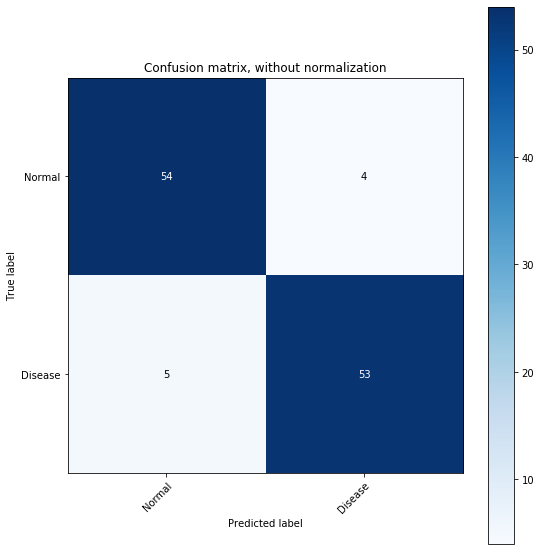

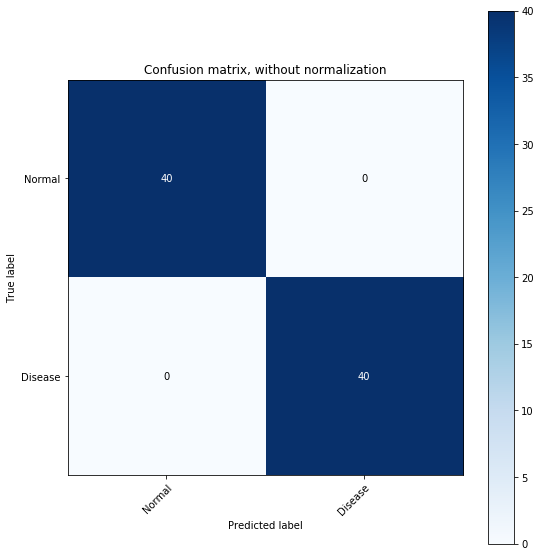

In [38]:
%time shallow_nw_results = runSubclusterAnalysis(cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

In [35]:
sum([x[1][1] for x in shallow_nw_results.values()])

90

In [36]:
# 
# total_specifity = 

- ### Better accuracy than original architecure being fed reduced features
- # Generally beats original non-subclustered analysis
- ### Not as good as orginal with subclustered data
    - **Thats expected however due to the implicit bias in the subclusters**


## NN w/ ALL features
- ### Performs just as well as original architecure with subcluster

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:0.327, Acc:0.9038
Prediction Accuracy
12/12 [==============================] - 0s 3ms/step
Scores on data set: loss=0.192 accuracy=1.0000
Fold Correct: 12
Running worker: 1
Fold: 1 -> Loss:0.366, Acc:0.8750
Prediction Accuracy
12/12 [==============================] - 0s 51us/step
Scores on data set: loss=0.160 accuracy=1.0000
Fold Correct: 12
Running worker: 2
Fold: 2 -> Loss:0.376, Acc:0.8846
Prediction Accuracy
12/12 [==============================] - 0s 61us/step
Scores on data set: loss=0.418 accuracy=0.8333
Fold Correct: 10
Running worker: 3
Fold: 3 -> Loss:0.373, Acc:0.8846
Prediction Accuracy
12/12 [==============================] - 0s 33us/step
Scores on data set: loss=0.296 accuracy=0.9167
Fold Correct: 11
Running worker: 4
Fold: 4 -> Loss:0.250, Acc:0.9519
Prediction Accuracy
12/12 [==============================] - 0s 33us/step
Scores on data set: loss=0.998 accuracy=0.7500
Fold Correct: 9
Running worker: 5
Fol

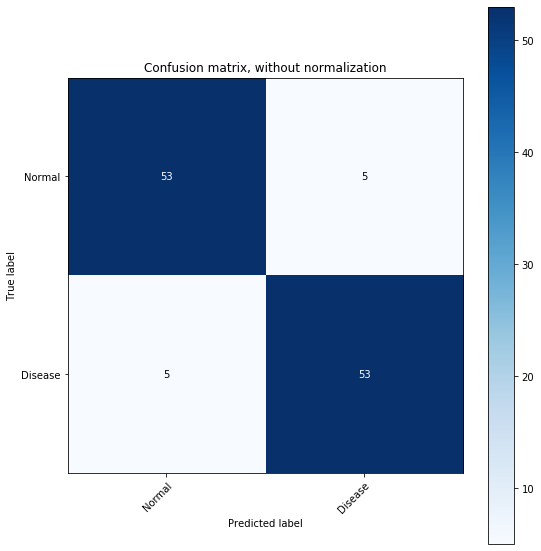

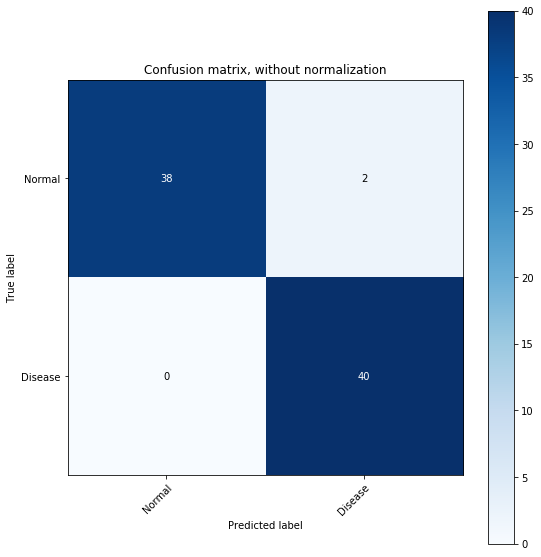

In [39]:
# non_red_cluster_train = pipeline.getSubclusters(reduce=False)
%time shallow_nw_results = runSubclusterAnalysis(non_red_cluster_train, build_shallow_dnn, batch_size=20, epochs=30)

## NN w/ original data

In [40]:
#### Skipping for now ####
nn = build_shallow_dnn(num_features=X_train.shape[1])

# shallow_pipeline = ClusterPipeline(nn, [X_train, y_train], [X_valid, y_valid], target_class=1)

# shallow_pipeline.train_model(batch_size=10,epochs=30, cross_validation=True, parallel=False, verbose=0)

# plot_confusion_matrix(y_train.values[shallow_pipeline.testing_idxs], np.array(shallow_pipeline.predictions, dtype=int), np.array(["Normal", "Disease"]))

# SVM Analysis

In [41]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["squared_hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]},
    { "max_iter":[10000000], "loss":["hinge"], "tol":[1e-4,1e-5,1e-6], "C":[1,10,100]}
]

lsvc = LinearSVC()


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC())
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(lsvc, param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=4))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, score

## SVM trained on original data

In [42]:
original_svm, score = runSVM(X_train, y_train, X_valid, y_valid)

{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.846(+/- 0.143)


## Trained on subcluster vs control only

In [45]:
for sc in non_red_cluster_train:
    X_train_sc, y_train_sc = non_red_cluster_train[sc]
    X_valid_red = X_valid[X_train_sc.columns]
    %time runSVM(X_train_sc, y_train_sc, X_valid_red, y_valid)

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.800
SVM CV Accuracy: 0.948(+/- 0.085)
CPU times: user 261 ms, sys: 58.7 ms, total: 319 ms
Wall time: 7.03 s
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.767
SVM CV Accuracy: 0.963(+/- 0.115)
CPU times: user 196 ms, sys: 5.31 ms, total: 201 ms
Wall time: 768 ms


## Trained on feature reduced subcluster
> ### Despite losing almost half the features, we still retain a high accuracy
> ### This may be an indication that the subclustering was infact a valid one

In [47]:
for sc in cluster_train:
    X_train_sc, y_train_sc = cluster_train[sc]
    X_valid_red = X_valid[X_train_sc.columns]
    %time runSVM(X_train_sc, y_train_sc, X_valid_red, y_valid)

{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.800
SVM CV Accuracy: 0.938(+/- 0.111)
CPU times: user 197 ms, sys: 5.04 ms, total: 202 ms
Wall time: 3.78 s
{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l1', 'tol': 0.0001}
SVM Test Accuracy: 0.800
SVM CV Accuracy: 0.975(+/- 0.100)
CPU times: user 196 ms, sys: 2.69 ms, total: 199 ms
Wall time: 610 ms
